### reference url:

- https://www.kaggle.com/code/ryanfox212/what-price-should-you-charge-for-your-airbnb
- https://www.kaggle.com/code/lingliboston/boston-airbnb-market-analysis


In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

- Calendar.csv : including listing id and the price and availability for that day
- Listings.csv : including full descriptions and average review score


In [112]:
df_calendar_b_origin = pd.read_csv("./data/Boston/calendar.csv")
df_listing_b_origin = pd.read_csv("./data/Boston/listings.csv")

## 2 . clean up the listing data


In [113]:
display(df_listing_b_origin.sample(3))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2319,6790961,https://www.airbnb.com/rooms/6790961,20160906204935,2016-09-07,Luxury 2BR in Boston/ Fenway Area.,"This 2 bedroom, apartment is centrally located...",NaN,"This 2 bedroom, apartment is centrally located...",none,NaN,...,10.0,f,NaN,NaN,f,strict,f,f,136,0.11
675,2043541,https://www.airbnb.com/rooms/2043541,20160906204935,2016-09-07,16 Battery McPhee’s Apartment (#1R),Larger 2 Bedroom that can accommodate 7. Ther...,NaN,Larger 2 Bedroom that can accommodate 7. Ther...,none,"Welcome to Boston’s North End, one of the olde...",...,9.0,f,NaN,NaN,f,strict,f,f,7,1.18
2842,5371051,https://www.airbnb.com/rooms/5371051,20160906204935,2016-09-07,Beautiful 3 bedroom Dorchester MA,"Private 3 bedroom, 3rd fl Apartment with dine-...",Historic Dorchester close to many amenities.,"Private 3 bedroom, 3rd fl Apartment with dine-...",none,It's walking distance to most necessities: gro...,...,9.0,f,NaN,NaN,f,moderate,f,f,1,2.58


In [114]:
df_listing_b_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [115]:
# identify cols has high missing value ratio, a single unique value, records url info, or very long txt info
def get_sub_columns_list(df, missing_ratio_cutoff):
    high_missing_cols = []
    missing_ratios = []
    single_value_cols = []
    single_values = []
    url_cols = []
    # long_txt_cols = []
    tf_cols = []  # true false nan

    total_listings = df.shape[0]
    tf_set = {"t", "f", np.nan}
    for col in df.columns:
        missing_ratio = round(df[col].isnull().sum() / total_listings, 2)
        # print(i)
        # if len((df[i]).unique()) == 1:
        #     print('col "{}" has a single unique value {}:'.format(i, (df[i]).unique()))
        #     single_value_cols = single_value_cols + [i]
        # elif len((df[i]).unique()) <= 3 and set((df[i]).unique()).issubset(tf_set):
        if len((df[col]).unique()) == 1:
            # print('col "{}" has a single unique value {}:'.format(i, (df[i]).unique()))
            single_value_cols = single_value_cols + [col]
            single_values = single_values + [(df[col]).unique()]
        elif missing_ratio >= missing_ratio_cutoff:
            # print('col "{}" missing value ratio is {}:'.format(i, missing_ratio))
            high_missing_cols = high_missing_cols + [col]
            missing_ratios = missing_ratios + [missing_ratio]
        elif "url" in col or "_id" in col or "name" in col:
            # print('col "{}" records url.'.format(i))
            url_cols = url_cols + [col]
        elif len((df[col]).unique()) <= 3 and set((df[col]).unique()).issubset(tf_set):
            # print("col {} has t/f values".format(col))
            tf_cols.append(col)
        # elif df[col].dtype == "object" and df[col].str.len().mean() > 100:
        #     print('col "{}" mean length is > 100.'.format(col))
        #     long_txt_cols = long_txt_cols + [col]

    print("tf_cols : {} ".format(len(tf_cols)))
    for col in tf_cols:
        print("    col {} has t/f values".format(col))

    print("high_missing_cols : {} ".format(len(high_missing_cols)))
    for col, missing_ratio in zip(high_missing_cols, missing_ratios):
        print('    col "{}" missing value ratio is {}:'.format(col, missing_ratio))

    print("single_value_cols : {} ".format(len(single_value_cols)))
    for col, val in zip(single_value_cols, single_values):
        print('    col "{}" has a single unique value {}:'.format(col, val))

    print("url_cols : {} ".format(len(url_cols)))
    for col in url_cols:
        print('    col "{}" records id, name or url.'.format(col))

    return tf_cols, high_missing_cols, single_value_cols, url_cols

In [116]:
(
    tf_cols,
    high_missing_cols,
    single_value_cols,
    url_cols,
) = get_sub_columns_list(df_listing_b_origin, 0.5)

tf_cols : 6 
    col host_is_superhost has t/f values
    col host_has_profile_pic has t/f values
    col is_location_exact has t/f values
    col instant_bookable has t/f values
    col require_guest_profile_picture has t/f values
    col require_guest_phone_verification has t/f values
high_missing_cols : 5 
    col "notes" missing value ratio is 0.55:
    col "square_feet" missing value ratio is 0.98:
    col "weekly_price" missing value ratio is 0.75:
    col "monthly_price" missing value ratio is 0.75:
    col "security_deposit" missing value ratio is 0.63:
single_value_cols : 12 
    col "scrape_id" has a single unique value [20160906204935]:
    col "last_scraped" has a single unique value ['2016-09-07']:
    col "experiences_offered" has a single unique value ['none']:
    col "neighbourhood_group_cleansed" has a single unique value [nan]:
    col "state" has a single unique value ['MA']:
    col "country_code" has a single unique value ['US']:
    col "country" has a single uni

In [117]:
# create df without unnecessary columns
irrelevant_cols = [
    "host_location",
    "host_listings_count",
    "calculated_host_listings_count",
    "host_verifications",
    "host_neighbourhood",
    "neighbourhood",
    "city",
    "state",
    "smart_location",
    "street",
    "weekly_price",
    "first_review",
]
drop_cols = high_missing_cols + single_value_cols + url_cols
df_listing_b = df_listing_b_origin.drop(columns=drop_cols)
df_listing_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 66 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   summary                           3442 non-null   object 
 2   space                             2528 non-null   object 
 3   description                       3585 non-null   object 
 4   neighborhood_overview             2170 non-null   object 
 5   transit                           2295 non-null   object 
 6   access                            2096 non-null   object 
 7   interaction                       2031 non-null   object 
 8   house_rules                       2393 non-null   object 
 9   host_since                        3585 non-null   object 
 10  host_location                     3574 non-null   object 
 11  host_about                        2276 non-null   object 
 12  host_r

In [118]:
# drop irrelevant columns (looks like)
irrelevant_cols = [
    "host_location",
    "host_listings_count",
    "calculated_host_listings_count",
    "host_verifications",
    "host_neighbourhood",
    "neighbourhood",
    "city",
    "smart_location",
    "street",
    "first_review",
    "availability_30",
    "bed_type",
    "availability_60",
    "availability_90",
    "availability_365",
    "host_neighbourhood",
    "host_total_listings_count",
    "review_scores_location",
    "zipcode",
    "market",
    "smart_location",
    "latitude",
    "longitude",
    "cleaning_fee",
    "guests_included",
    "extra_people",
    "minimum_nights",
    "maximum_nights",
    "calendar_updated",
    "last_review",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
]
df_listing_b = df_listing_b.drop(columns=irrelevant_cols)
df_listing_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   summary                           3442 non-null   object 
 2   space                             2528 non-null   object 
 3   description                       3585 non-null   object 
 4   neighborhood_overview             2170 non-null   object 
 5   transit                           2295 non-null   object 
 6   access                            2096 non-null   object 
 7   interaction                       2031 non-null   object 
 8   house_rules                       2393 non-null   object 
 9   host_since                        3585 non-null   object 
 10  host_about                        2276 non-null   object 
 11  host_response_time                3114 non-null   object 
 12  host_r

In [119]:
# transfer tf to 01
def chg_col_tf_to_01(x):
    if x == "f":
        x = 0
    elif x == "t":
        x = 1
    else:
        x = 0
    return x


df_listing_b[tf_cols] = df_listing_b[tf_cols].applymap(chg_col_tf_to_01)
df_listing_b[tf_cols]

,host_is_superhost,host_has_profile_pic,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,0,1,1,0,0,0
1,0,1,1,1,0,0
2,1,1,1,0,1,0
3,0,1,0,0,0,0
4,1,1,1,0,0,0
...,...,...,...,...,...,...
3580,0,1,1,1,0,0
3581,0,1,0,0,0,0
3582,0,1,0,0,0,0
3583,0,1,1,0,0,0


In [122]:
# meney_cols = ["price"]
# def chg_col_dollar_str_to_float(col):
    # return col.str.strip("$").str.replace(",", "").astype(float)
def chg_col_dollar_str_to_float(val):
    return float(val.replace("$|,", ""))


display(df_listing_b["price"].sample(3))
df_listing_b["price"] = df_listing_b["price"].apply(chg_col_dollar_str_to_float)
display(df_listing_b["price"].sample(3))

660     $150.00
3039    $200.00
2708    $100.00
Name: price, dtype: object

812      99.00
2314    169.00
696     200.00
Name: price, dtype: object

In [83]:
display(df_listing_b["host_since"].sample(3))
df_listing_b["host_since_years"] = (
    2018 - pd.to_datetime(df_listing_b["host_since"]).dt.year
)
df_listing_b = df_listing_b.drop(columns=["host_since"])
display(df_listing_b["host_since_years"].sample(3))

1197    2012-04-25
2085    2015-11-19
2681    2010-01-19
Name: host_since, dtype: object

512     9
1209    7
3207    3
Name: host_since_years, dtype: int64

In [84]:
change_string_to_float_cols = ["host_response_rate", "host_acceptance_rate"]
display(df_listing_b[change_string_to_float_cols].sample(3))


def chg_col_rate_str_to_float(col):
    """
    strip %, change to float
    """
    return col.str.strip("%").astype(float)


df_listing_b[change_string_to_float_cols] = df_listing_b[
    change_string_to_float_cols
].apply(chg_col_rate_str_to_float)
display(df_listing_b[change_string_to_float_cols].sample(3))

,host_response_rate,host_acceptance_rate
1686,100%,94%
2925,79%,100%
183,100%,20%


,host_response_rate,host_acceptance_rate
1997,NaN,NaN
3310,100.0,95.0
2527,90.0,100.0


In [85]:
display(df_listing_b["host_response_time"].sample(3))
rsps_time_map = {
    "within an hour": 1,
    "within a few hours": 4,
    "within a day ": 24,
    "a few days or more": 48,
}
df_listing_b["host_response_time"] = df_listing_b["host_response_time"].map(
    rsps_time_map
)
display(df_listing_b["host_response_time"].sample(3))

2453        within an hour
1558        within an hour
3328    a few days or more
Name: host_response_time, dtype: object

3504    1.0
1608    1.0
1898    1.0
Name: host_response_time, dtype: float64

In [86]:
# Define description features
description_features = [
    "summary",
    "space",
    "description",
    "neighborhood_overview",
    "transit",
    "access",
    "interaction",
    "house_rules",
    "host_about",
]

# Convert null values to empty strings
df_listing_b[description_features] = df_listing_b[description_features].apply(
    lambda col: col.fillna(""), axis=1
)

# Convert description features to character counts
for column in df_listing_b[description_features]:
    df_listing_b[column] = df_listing_b[column].apply(lambda x: len(x))

In [87]:
# Convert amenities to amenities_count
display(df_listing_b["amenities"].sample(3))
df_listing_b["amenities_count"] = df_listing_b.amenities.str.count(",") + 1
df_listing_b = df_listing_b.drop(columns=["amenities"], axis=1)
display(df_listing_b["amenities_count"].sample(3))

20      {Internet,"Wireless Internet","Air Conditionin...
714     {TV,Internet,"Wireless Internet","Air Conditio...
2889    {TV,"Cable TV",Internet,"Wireless Internet","A...
Name: amenities, dtype: object

1986    14
2717    17
789     11
Name: amenities_count, dtype: int64

In [88]:
# examine category cols with a few unique values
def examine_category_cols(df):
    o_cols = df.select_dtypes(include="object").columns.tolist()
    o = df[o_cols].describe()
    o.loc["unique"].astype(int).describe()
    unique_value_cutoff = o.loc["unique"].astype(int).describe().loc["50%"]
    # cols_check_unique_value = o.columns.values[o.loc["unique"] < unique_value_cutoff]
    # for c in cols_check_unique_value:
    for c in o.columns:
        print("***********************")
        s = df[c].value_counts(dropna=False, normalize=True)
        print(s)
    # print(
    #     "{} out of {} object cols unique value examined".format(
    #         len(cols_check_unique_value), len(o_cols)
    #     )
    # )


examine_category_cols(df_listing_b)

***********************
Jamaica Plain              0.095676
South End                  0.090934
Back Bay                   0.084240
Fenway                     0.080893
Dorchester                 0.075035
Allston                    0.072524
Beacon Hill                0.054114
Brighton                   0.051604
South Boston               0.048536
Downtown                   0.047978
East Boston                0.041841
Roxbury                    0.040167
North End                  0.039888
Mission Hill               0.034589
Charlestown                0.030962
South Boston Waterfront    0.023152
Chinatown                  0.019805
Roslindale                 0.015621
West End                   0.013668
West Roxbury               0.012831
Hyde Park                  0.008647
Mattapan                   0.006695
Bay Village                0.006695
Longwood Medical Area      0.002510
Leather District           0.001395
Name: neighbourhood_cleansed, dtype: float64
***********************
Apartme

In [89]:
display(df_listing_b.select_dtypes(include="object").sample(5))

,neighbourhood_cleansed,property_type,room_type,cancellation_policy
3466,Allston,Apartment,Private room,flexible
1478,Back Bay,Apartment,Entire home/apt,strict
546,Bay Village,Apartment,Entire home/apt,strict
507,Mission Hill,Apartment,Shared room,strict
3140,South Boston,Apartment,Private room,moderate


In [90]:
df_listing_b = pd.get_dummies(
    df_listing_b,
    columns=[
        "neighbourhood_cleansed",
        "property_type",
        "room_type",
        "cancellation_policy",
    ],
)

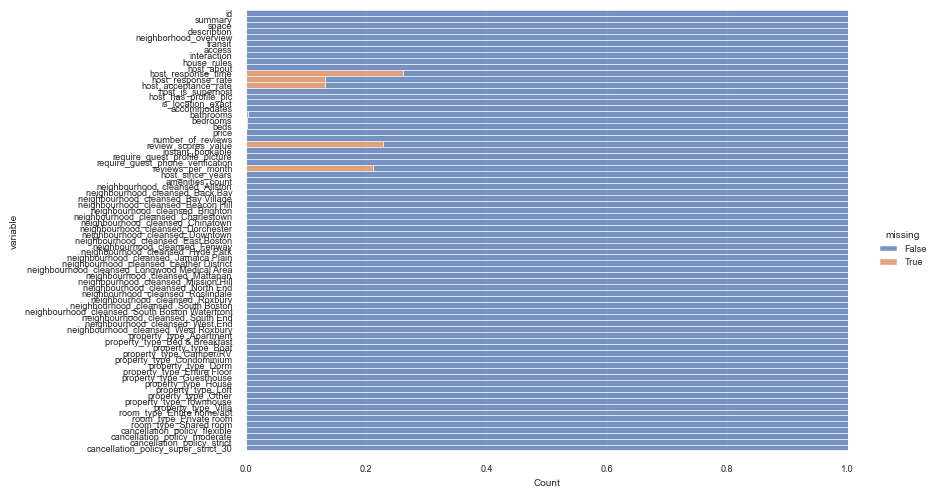

In [91]:
# visualize missing values
sns.set(font_scale=0.6)
sns.displot(
    data=df_listing_b.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.75,
)

<Axes: >

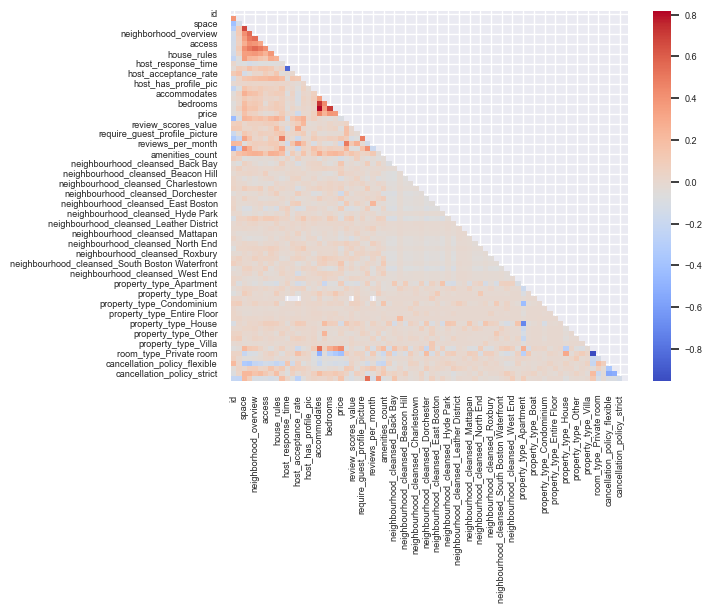

In [92]:
corr = df_listing_b.select_dtypes(exclude="object").corr()
# corr=corr[(corr>0.6)|(corr<-0.6)]
matrix = np.triu(corr)
sns.heatmap(corr, cmap="coolwarm", annot=False, mask=matrix)

## 3 . clean up the calendar data

In [93]:
display(df_calendar_b_origin.sample(3))

,listing_id,date,available,price
902725,951476,2017-06-05,t,$359.00
805808,8187052,2016-12-26,t,$342.00
272384,9259184,2017-04-11,t,$534.00


In [94]:
df_calendar_b_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [162]:
# drop rows without price
df_calendar_b = df_calendar_b_origin.dropna(subset=["price"], axis=0).copy()

# convert price from string to float
df_calendar_b["price"] = df_calendar_b["price"].apply(chg_col_dollar_str_to_float)

# get the month from date and remove the date column
df_calendar_b["month"] = pd.to_datetime(df_calendar_b["date"]).dt.month

df_calendar_b.drop(columns=["date", "available"], inplace=True)

In [163]:
display(df_calendar_b.sample(3))

,listing_id,price,month
440275,1214214,450.00,4
931607,8404805,225.00,2
481259,13592,359.00,2


## 4 . merge these two DataFrames into one 

In [164]:
df_b = (
    pd.merge(
        df_listing_b, df_calendar_b, how="left", left_on="id", right_on="listing_id"
    )
    .drop(["price_x", "listing_id"], axis=1)
    .rename({"price_y": "price"}, axis=1)
    .dropna(subset=["price"])
)


df_b

,id,summary,space,description,neighborhood_overview,transit,access,interaction,house_rules,host_since,...,amenities,number_of_reviews,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,price,month
1,3075044,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,"The room is in Roslindale, a diverse and prima...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,2012-06-07,...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",36,9.0,1,moderate,0,0,1.3,65.00,8.0
2,3075044,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,"The room is in Roslindale, a diverse and prima...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,2012-06-07,...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",36,9.0,1,moderate,0,0,1.3,65.00,8.0
3,3075044,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,"The room is in Roslindale, a diverse and prima...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,2012-06-07,...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",36,9.0,1,moderate,0,0,1.3,65.00,8.0
4,3075044,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,"The room is in Roslindale, a diverse and prima...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,2012-06-07,...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",36,9.0,1,moderate,0,0,1.3,75.00,8.0
5,3075044,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,"The room is in Roslindale, a diverse and prima...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,2012-06-07,...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",36,9.0,1,moderate,0,0,1.3,75.00,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643711,14504422,My place is close to My home is a warm and fri...,To ensure a smooth check in: 1. You MUST have ...,My place is close to My home is a warm and fri...,NaN,NaN,NaN,NaN,NaN,2015-08-20,...,"{""Wireless Internet"",Kitchen,Essentials,""trans...",0,NaN,1,flexible,0,0,NaN,62.00,9.0
643712,14504422,My place is close to My home is a warm and fri...,To ensure a smooth check in: 1. You MUST have ...,My place is close to My home is a warm and fri...,NaN,NaN,NaN,NaN,NaN,2015-08-20,...,"{""Wireless Internet"",Kitchen,Essentials,""trans...",0,NaN,1,flexible,0,0,NaN,62.00,9.0
643713,14504422,My place is close to My home is a warm and fri...,To ensure a smooth check in: 1. You MUST have ...,My place is close to My home is a warm and fri...,NaN,NaN,NaN,NaN,NaN,2015-08-20,...,"{""Wireless Internet"",Kitchen,Essentials,""trans...",0,NaN,1,flexible,0,0,NaN,62.00,9.0
643714,14504422,My place is close to My home is a warm and fri...,To ensure a smooth check in: 1. You MUST have ...,My place is close to My home is a warm 